![](img/TOC.svg)

# Advanced pyPRISM

While we have attempted to cover the basic usage of pyPRISM in this tutorial, there are inevitably use cases that are more complicated. Here we try to go over a few more advanced topics of pyPRISM. As with the previous notebook, we assume a slightly higher level of programming and a familiarity with pyPRISM here. 

## Notebook Setup
To begin, please run `Kernel-> Restart & Clear Output` from the menu at the top of the notebook. It is a good idea to run this before starting any notebook so that the notebook is fresh for the user. Next, run the cell below (via the top menu-bar or `<Shift-Enter>`. If the cell throws an import error, there is likely something wrong with your environment.

If successful, you should see a set of logos appear below the cell. Which logos appear depend on what is inside the `hv.extension()` command at the bottom of the cell. If no logos appear and the cell throws an error, there is likely something wrong with your environment. 

### Troubleshooting:
- Did you activate the correct conda environment before starting the jupyter notebook? 
- If not using anaconda, did you install all dependencies before starting the jupyter notebook? 
- Is pyPRISM installed in your current environment on your `PYTHONPATH`? 

Holoviews + Bokeh Logos: ![Logos](img/import_check_bokeh.png)


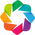

In [1]:
import numpy as np
import pyPRISM
import holoviews as hv
hv.extension('bokeh')

## Adding a new class or feature to pyPRISM

As users seek to use pyPRISM for new studies, they will likely need a potential, $\omega$, or closure that is not currently implemented. Here we briefly cover how to create a new class for use in pyPRISM.

As an example, we will work on a new Potential: the square well potential. The only requirements of this class are that  the class inherits from Potential and that it provides a calculate method which returns the potential magnitude given an array of positions to calculate at. If these are satistified, then this class can be used in pyPRISM! Note that this contract is the same for closures and $\omega$ as well.

We create the class with three attributes which describe the width and depth of the attractive square well along with the contact distance.

In [2]:
from pyPRISM.potential.Potential import Potential
import numpy as np

class SquareWell(Potential):
    def __init__(self,depth,width,sigma,high_value=1e6):
        r'''Constructor
        
        Attributes
        ----------
        depth: float
            depth of attractive well
            
        width: float
            width of attractive well. Note that this is 
            the width *beyond* the contact distance (sigma)
        
        sigma: float
            contact distance
            
        high_value: float
            value of potential when overlapping
        '''
        self.sigma = sigma
        self.width = sigma + width
        self.depth = depth
        self.high_value = high_value
    def calculate(self,r):
        r'''Calculate potential values

        Attributes
        ----------
        r: float np.ndarray
            Array of pair distances at which to calculate potential values
        '''
        magnitude = np.zeros_like(r)
        magnitude[r<self.width] = -self.depth
        magnitude[r<self.sigma] = self.high_value
        return magnitude
        


Below we plot several versions of the potential with different parameters to verify our implementation.

In [3]:
#holoviews parameters
extents = (0,-5,6,5)
plotParm = {'width':500,'height':400}
styleParm = {}

domain = pyPRISM.Domain(length=1024,dr=0.1)


HS = pyPRISM.potential.HardSphere(sigma=1.0)
U = HS.calculate(domain.r)

curve = hv.Curve((domain.r,U),label='Hard Sphere',extents=extents)(style=styleParm,plot=plotParm)
curves = [curve]
for width in [1.5,3]:
    for depth in [2,4]:
        SW = SquareWell(depth=depth,width=width,sigma=1.0)
        U = SW.calculate(domain.r)
        
        label = 'width:{} depth:{}'.format(width,depth)
        curve = hv.Curve((domain.r,U),label=label,extents=extents)(style=styleParm,plot=plotParm)
        curves.append(curve)

hv.Overlay(curves)

:Overlay
   .Curve.Hard_Sphere                             :Curve   [x]   (y)
   .Curve.Width_colon_1_full_stop_5_depth_colon_2 :Curve   [x]   (y)
   .Curve.Width_colon_1_full_stop_5_depth_colon_4 :Curve   [x]   (y)
   .Curve.Width_colon_3_depth_colon_2             :Curve   [x]   (y)
   .Curve.Width_colon_3_depth_colon_4             :Curve   [x]   (y)

Here we use the above defines potential for a simple PRISM calculation of a square well fluid and compare it to the hard sphere fluid.

In [4]:
diameter = 1.0

print('== Hard Sphere Calculation ==')
sys = pyPRISM.System(['monomer'],kT=1.0)
sys.domain = pyPRISM.Domain(dr=0.01,length=16384)
sys.diameter['monomer'] = diameter
sys.potential['monomer','monomer'] = pyPRISM.potential.HardSphere(sigma=diameter)
sys.density['monomer'] = 0.9
sys.omega['monomer','monomer'] = pyPRISM.omega.SingleSite()
sys.closure['monomer','monomer'] = pyPRISM.closure.HyperNettedChain(apply_hard_core=True)
PRISM = sys.createPRISM()
PRISM.solve()
guess = np.copy(PRISM.x)

x = sys.domain.r 
y = pyPRISM.calculate.pair_correlation(PRISM)['monomer','monomer']
rdf1 = hv.Curve((x,y),extents=(0,0,6,None),label='Hard Sphere').redim.label(x='r',y='g(r)')

print('== Square Well Calculation ==')
sys.potential['monomer','monomer'] = SquareWell(sigma=diameter,width=1.0,depth=0.3)
PRISM = sys.createPRISM()
PRISM.solve(guess=guess)
x = sys.domain.r 
y = pyPRISM.calculate.pair_correlation(PRISM)['monomer','monomer']
rdf2 = hv.Curve((x,y),extents=(0,0,6,None),label='Square Well').redim.label(x='r',y='g(r)')

== Hard Sphere Calculation ==
0:  |F(x)| = 2.84918; step 0.221669; tol 0.571933
1:  |F(x)| = 2.32298; step 0.306827; tol 0.598267
2:  |F(x)| = 1.93093; step 0.22343; tol 0.621845
3:  |F(x)| = 1.68305; step 0.17015; tol 0.683765
4:  |F(x)| = 1.45965; step 0.251084; tol 0.676929
5:  |F(x)| = 1.26112; step 0.158712; tol 0.671826
6:  |F(x)| = 1.25398; step 1; tol 0.889845
7:  |F(x)| = 1.07937; step 0.167843; tol 0.712642
8:  |F(x)| = 0.875799; step 0.343204; tol 0.592534
9:  |F(x)| = 0.864542; step 1; tol 0.877011
10:  |F(x)| = 0.811171; step 1; tol 0.792311
11:  |F(x)| = 0.784741; step 1; tol 0.842306
12:  |F(x)| = 0.782169; step 1; tol 0.894111
13:  |F(x)| = 0.781836; step 1; tol 0.899233
14:  |F(x)| = 0.781789; step 1; tol 0.899892
15:  |F(x)| = 0.781781; step 1; tol 0.899983
16:  |F(x)| = 0.595288; step 0.336799; tol 0.728972
17:  |F(x)| = 0.443791; step 0.49023; tol 0.500203
18:  |F(x)| = 0.269123; step 1; tol 0.330969
19:  |F(x)| = 0.0299694; step 1; tol 0.0111608
20:  |F(x)| = 5.337

Plotting the Results

In [5]:
hv.Overlay([rdf1,rdf2])(plot=plotParm)

:Overlay
   .Curve.Hard_Sphere :Curve   [x]   (y)
   .Curve.Square_Well :Curve   [x]   (y)

![](img/tracks.svg)

[NB0.Introduction](NB0.Introduction.ipynb) $\cdot$   [NB1.PythonBasics](NB1.PythonBasics.ipynb) $\cdot$   [NB2.Theory.General](NB2.Theory.General.ipynb) $\cdot$   [NB3.Theory.PRISM](NB3.Theory.PRISM.ipynb) $\cdot$   [NB4.pyPRISM.Overview](NB4.pyPRISM.Overview.ipynb) $\cdot$   [NB5.CaseStudies.PolymerMelts](NB5.CaseStudies.PolymerMelts.ipynb) $\cdot$   [NB6.CaseStudies.Nanocomposites](NB6.CaseStudies.Nanocomposites.ipynb) $\cdot$   [NB7.CaseStudies.Copolymers](NB7.CaseStudies.Copolymers.ipynb) $\cdot$   [NB8.pyPRISM.Internals](NB8.pyPRISM.Internals.ipynb) $\cdot$   [NB9.pyPRISM.Advanced](NB9.pyPRISM.Advanced.ipynb) 